# FZD5
[microphthalmia/coloboma-11 (MCOPCB11)](https://omim.org/entry/620731) is caused by heterozygous mutation in the FZD5 gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.9.1


### FZD5
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FZD5.

In [2]:
gene_symbol = 'FZD5'
mane_tx_id = 'NM_003468.4'
mane_protein_id = 'NP_065979.1' # zinc finger SWIM domain-containing protein 6"

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.23') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

qc_results.summarize()

Individuals Processed: 100%|██████████| 29/29 [00:27<00:00,  1.06individuals/s]
Validated under permissive policy
No errors or warnings were found


In [10]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Iris coloboma,HP:0000612,16
Nystagmus,HP:0000639,9
Chorioretinal coloboma,HP:0000567,7
Retinal coloboma,HP:0000480,7
Optic disc hypoplasia,HP:0007766,7
Reduced visual acuity,HP:0007663,7
Optic disc coloboma,HP:0000588,5
High myopia,HP:0011003,5
High hypermetropia,HP:0008499,3
Microphthalmia,HP:0000568,2


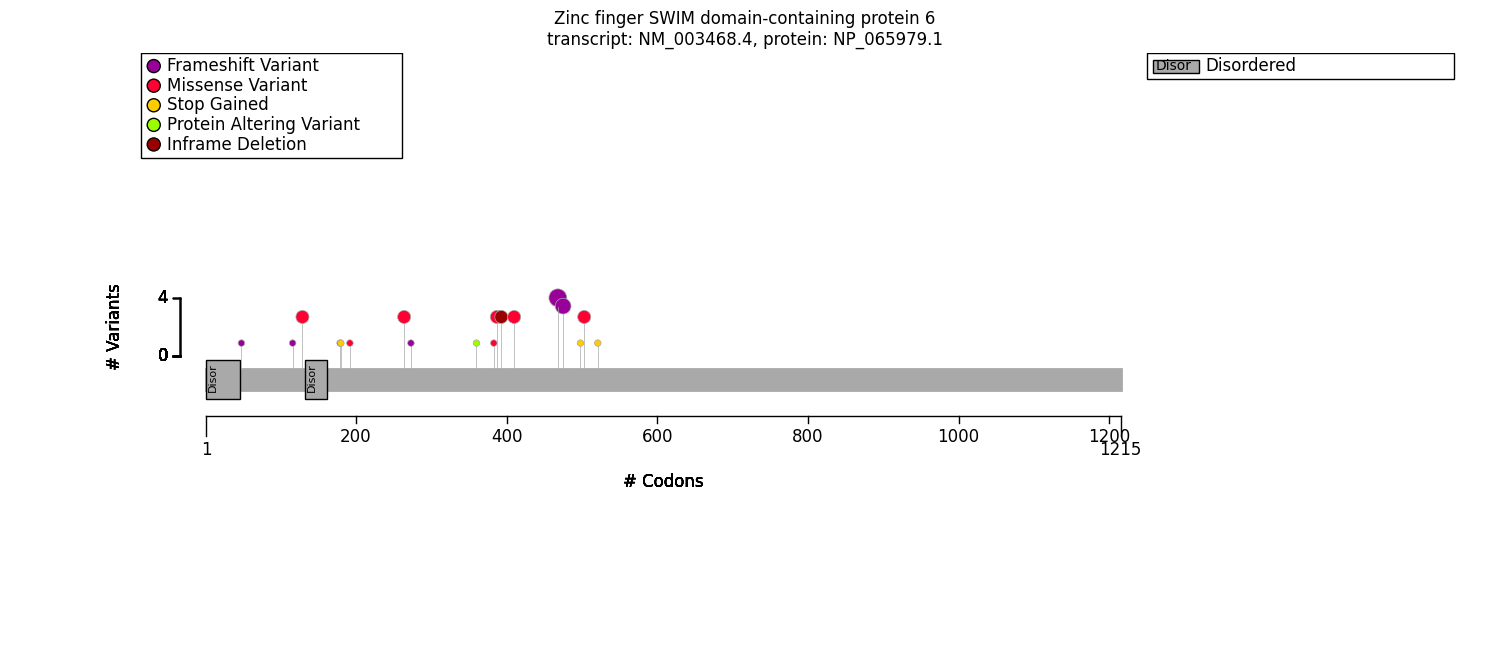

In [11]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fzd5_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fzd5_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [13]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [14]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = monoallelic_predicate(a_predicate=missense, 
                                           b_predicate=~missense, 
                                           a_label="missense", 
                                           b_label="other")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,9
HMF08,Skipping general term,15
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,23


In [16]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                 missense          other          \
                                                Count Percent  Count Percent   
Iris coloboma [HP:0000612]                       4/13     31%  12/16     75%   
Retinal coloboma [HP:0000480]                     2/8     25%    5/6     83%   
Optic disc coloboma [HP:0000588]                  0/3      0%    5/9     56%   
Optic disc hypoplasia [HP:0007766]                5/8     62%    2/6     33%   
Coloboma [HP:0000589]                             5/5    100%  14/14    100%   
Abnormality iris morphology [HP:0000525]          4/4    100%  12/12    100%   
Chorioretinal coloboma [HP:0000567]               2/3     67%    5/9     56%   
Abnormal fundus morphology [HP:0001098]         10/10    100%  15/15    100%   
Abnormal retinal morphology [HP:0000479]          5/5    100%  10/10    100%   
Abnormal optic nerve morphology [HP:0000587]      5/5    100%    7/7    100%   
Reduced visual acuity [HP:0007663]                4/8     50%    3/6     50%   

Allele group                                                               
                                             Corrected p values  p values  
Iris coloboma [HP:0000612]                             0.297588  0.027053  
Retinal coloboma [HP:0000480]                          0.564103  0.102564  
Optic disc coloboma [HP:0000588]                       0.750000  0.204545  
Optic disc hypoplasia [HP:0007766]                     1.000000  0.592075  
Coloboma [HP:0000589]                                  1.000000  1.000000  
Abnormality iris morphology [HP:0000525]               1.000000  1.000000  
Chorioretinal coloboma [HP:0000567]                    1.000000  1.000000  
Abnormal fundus morphology [HP:0001098]                1.000000  1.000000  
Abnormal retinal morphology [HP:0000479]               1.000000  1.000000  
Abnormal optic nerve morphology [HP:0000587]           1.000000  1.000000  
Reduced visual acuity [HP:0007663]                     1.000000  1.000000

# Summary

In [17]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
)


caption = "No significant correlations identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [18]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,11,0


In [19]:
summarizer.process_latex(report=report, protein_fig=fzd5_fig)

Figure saved to ../../supplement/img/FZD5_protein_diagram-draft.pdf
Output to ../../supplement/tex/FZD5_summary_draft.tex
